In [78]:
import sys
import os
sys.path.append("..")
from commembed.jupyter import *
import commembed.linalg as linalg
import commembed.dimens as dimens
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from tqdm.notebook import tqdm
tqdm.pandas()
%config InlineBackend.figure_format = 'retina'
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
from pyspark.sql.functions import *

import commembed.data as data
import commembed.analysis as analysis


spark = data.spark_context()

%load_ext autoreload
%autoreload 2

Spark WebUI: http://ada.ais.sandbox:4049
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [79]:
monthly_user_counts = data.load("all_objects_monthly_user_counts")
monthly_user_counts.createOrReplaceTempView("monthly_user_counts")

In [80]:
monthly_user_counts.columns

['author', 'subreddit', 'month', 'num_comments']

In [81]:
embedding = load_embedding('reddit', 'master')
dimen_list = dimens.load_dimen_list('final')
scores = dimens.score_embedding(embedding, dimen_list)

In [82]:
partisan_dimen = "partisan"

In [83]:
left_thresh = np.mean(scores[partisan_dimen]) - np.std(scores[partisan_dimen])*2
right_thresh = np.mean(scores[partisan_dimen]) + np.std(scores[partisan_dimen])*2
is_left_leaning = scores[partisan_dimen] <= left_thresh
is_right_leaning = scores[partisan_dimen] >= right_thresh
is_political = scores[partisan_dimen+"_neutral"] >= neutral_cutoffs[partisan_dimen]

cat = np.where(is_left_leaning, 2 - is_political.astype(int),
        np.where(is_right_leaning, 4 + is_political.astype(int), 3))
scores["cat"] = cat

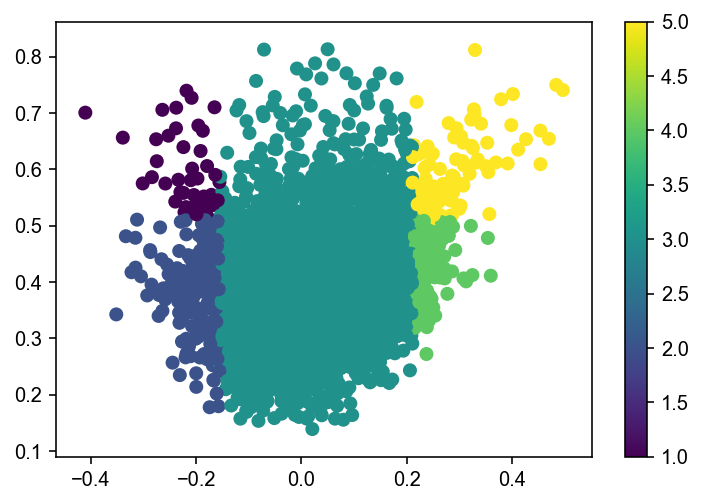

In [85]:
plt.figure()
plt.scatter(scores[partisan_dimen], scores[partisan_dimen+"_neutral"], c=scores["cat"])
plt.colorbar()
plt.show()

In [86]:
mos = ["%04d-%02d" % (yr,mo) for yr in range(2008, 2019) for mo in range(1, 13)]
mos_df = pd.DataFrame(mos).reset_index().rename(columns={"index":"month_ordinal",0:"month_name"})
spark.createDataFrame(mos_df).createOrReplaceTempView("mos")
mos_df.head(5)

,month_ordinal,month_name
0,0,2008-01
1,1,2008-02
2,2,2008-03
3,3,2008-04
4,4,2008-05


In [87]:
spark.createDataFrame(scores.reset_index()).createOrReplaceTempView("scores")


user_first_months = spark.sql("""

    select author, cat, min(month) as min_month
    from monthly_user_counts

    inner join scores
    on community = subreddit
    
    --where num_comments > 5
    
    group by 1, 2

""").cache()
user_first_months.show()

+--------------------+---+---------+
|              author|cat|min_month|
+--------------------+---+---------+
|     ----------_----|  3|  2015-12|
|             ------6|  3|  2015-09|
|     ----PINKGUY----|  3|  2019-02|
|    ----Somebody----|  4|  2019-03|
|           ----Toast|  3|  2019-08|
|            ---0_o--|  3|  2019-03|
|---DONTDIEWEMULTIPLY|  1|  2016-11|
|          ---Mr_J---|  3|  2016-12|
|        ---Sakura---|  2|  2017-08|
|    ---_---_---_---7|  1|  2017-01|
|         ---___---__|  3|  2018-01|
|        ---deleted--|  3|  2013-01|
|        ---gemini---|  3|  2016-06|
|        ---hyphen---|  3|  2019-11|
|         ---shade---|  2|  2018-04|
|                --06|  4|  2018-03|
|             --555--|  3|  2019-06|
|              --Ant-|  3|  2017-07|
|--Dont_PM_me_Asses--|  4|  2019-12|
|      --I_am_GROOT--|  3|  2018-12|
+--------------------+---+---------+
only showing top 20 rows



In [88]:
user_first_months.createOrReplaceTempView("user_first_months")
pivoted_users = spark.sql("""
    select * from user_first_months
    pivot ( first(min_month) for cat in (1, 2, 3, 4, 5) )
""").cache()
pivoted_users.show()

+-------------------+-------+-------+-------+-------+-------+
|             author|      1|      2|      3|      4|      5|
+-------------------+-------+-------+-------+-------+-------+
|-----BERSERKER-----|   null|   null|2017-11|   null|   null|
|   ----____----____|   null|   null|2013-12|   null|2017-10|
|     ----darkmatter|   null|   null|2019-12|   null|   null|
|        ---Eagle---|2015-10|2016-07|2015-10|2015-10|2015-10|
|        ---FELIX---|   null|   null|2016-09|   null|   null|
|       ---JustMe---|   null|2014-12|2014-02|2014-04|2014-02|
|            ---NoTy|   null|2018-06|2018-04|2018-06|2018-06|
|   ---Tsing__Tao---|   null|2019-06|2018-12|2019-05|2019-02|
|         ---USER---|   null|   null|2015-02|   null|   null|
|         ---blonded|   null|   null|2018-09|   null|   null|
|    ---idontknow---|   null|   null|2019-10|   null|   null|
|              ---ll|   null|   null|2019-12|   null|   null|
|          ---ttt---|   null|   null|2018-07|   null|   null|
|       

adjust `cat_a` and `cat_b` here

------

In [89]:
cat_a = 2
cat_b = 1

In [90]:
pivoted_users.createOrReplaceTempView("pivoted_users")

monthly_totals = spark.sql(f"""

    select `{cat_b}` as month_cat_b, count(*) as total_users,
       count(`{cat_a}`) as total_cat_a,
       avg(cast(coalesce(`{cat_a}`, 'zzzzzzz') < `{cat_b}` as int)) as pct_cat_a_before,
       avg(cast(coalesce(`{cat_a}`, 1000) == `{cat_b}` as int)) as pct_cat_a_same
    from pivoted_users
    group by 1

""").toPandas()

(0, 1)

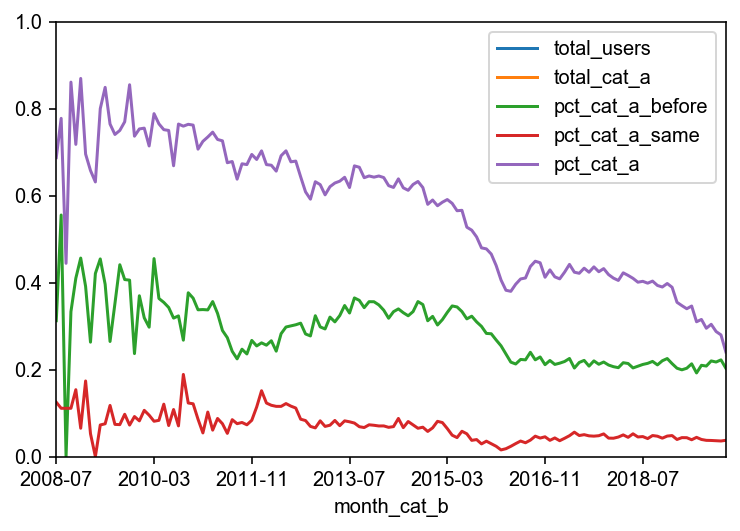

In [91]:
monthly_totals["pct_cat_a"] = monthly_totals["total_cat_a"] / monthly_totals["total_users"]
ax = monthly_totals.sort_values("month_cat_b").iloc[:-1].plot.line(x="month_cat_b")
ax.set_ylim(0,1)

In [92]:
monthly_totals.to_csv(data.DATA_PATH+'/implicit_user_counts_cat_%d_to_%d_%s.csv' % (cat_a, cat_b, partisan_dimen))

In [93]:
plot_data = pivoted_users.groupBy([str(cat_a),str(cat_b)]).agg({"author":"count"}).toPandas()
plot_data

,2,1,count(author)
0,2015-08,2015-08,535
1,2012-02,2015-09,23
2,2019-10,2019-03,127
3,2013-06,2011-04,4
4,2018-09,2018-07,211
...,...,...,...
14497,2008-03,2008-08,1
14498,2010-09,2009-09,1
14499,2009-07,2016-11,1
14500,2014-02,2011-12,1


In [94]:
plot_data_no_na = plot_data[~(plot_data[str(cat_a)].isna() | plot_data[str(cat_b)].isna())]

In [95]:
plot_data_no_na

,2,1,count(author)
0,2015-08,2015-08,535
1,2012-02,2015-09,23
2,2019-10,2019-03,127
3,2013-06,2011-04,4
4,2018-09,2018-07,211
...,...,...,...
14497,2008-03,2008-08,1
14498,2010-09,2009-09,1
14499,2009-07,2016-11,1
14500,2014-02,2011-12,1


In [96]:
totals = plot_data_no_na.groupby(str(cat_b)).agg({"count(author)":"sum"})

In [97]:
totals

,count(author)
1,
2008-07,11
2008-08,7
2008-09,4
2008-10,31
2008-11,28
...,...
2019-08,6387
2019-09,5084
2019-10,4511


In [98]:
reindexed = plot_data_no_na.set_index([str(cat_a), str(cat_b)]).reindex([(m1, m2) for m1 in mos for m2 in mos]).reset_index()

In [99]:
np.mean(~plot_data[str(cat_b)].isna())

0.9898634671079851

In [100]:
reindexed["proportions"] = reindexed["count(author)"] / monthly_totals.set_index("month_cat_b")["total_users"].reindex(reindexed[str(cat_b)]).values

In [101]:
pivoted = reindexed.reset_index(drop=True).pivot(index=str(cat_a), columns=str(cat_b), values='proportions')

In [102]:
pivoted.to_csv(data.DATA_PATH+"/heatmap_%s_to_%s_%s.csv" % (cat_a, cat_b, partisan_dimen))

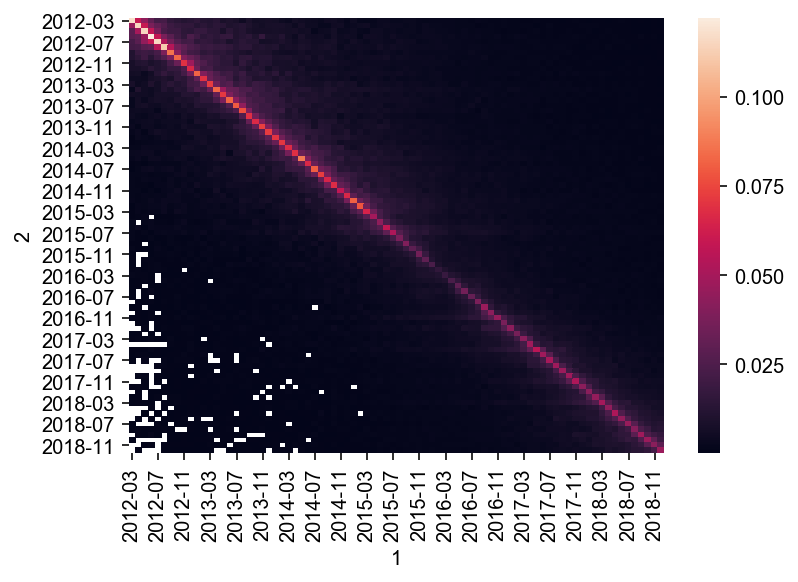

In [103]:
import seaborn as sns
sns.heatmap(pivoted.iloc[50:, 50:])

[       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan 0.53510182        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan 0.58811381        nan
        nan        nan 0.58951084        nan        nan        nan
 0.58818856 0.56760621 0.53842869 0.55054868        nan        nan
 0.54915925 0.53737284 0.51803349 0.52128575 0.48316052 0.47729813
 0.46432969 0.43863594 0.43857715 0.42801277 0.39581668 0.36394065
 0.34295461 0.34339403 0.361826   0.37431293 0.37110087 0.39916309
 0.41455595 0.40178156 0.37676039 0.39313611 0.3760054  0.37035952
 0.38191936 0.40281316 0.38534237 0.38013412 0.39103013 0.37844803
 0.39137103 0.37967383 0.38295269 0.36178793 0.35448312 0.34962797
 0.3601453  0.35671078 0.34395179 0.33308919 0.3246801  0.3199803
 0.31579379 0.29661069 0.28052148 0.26747889]


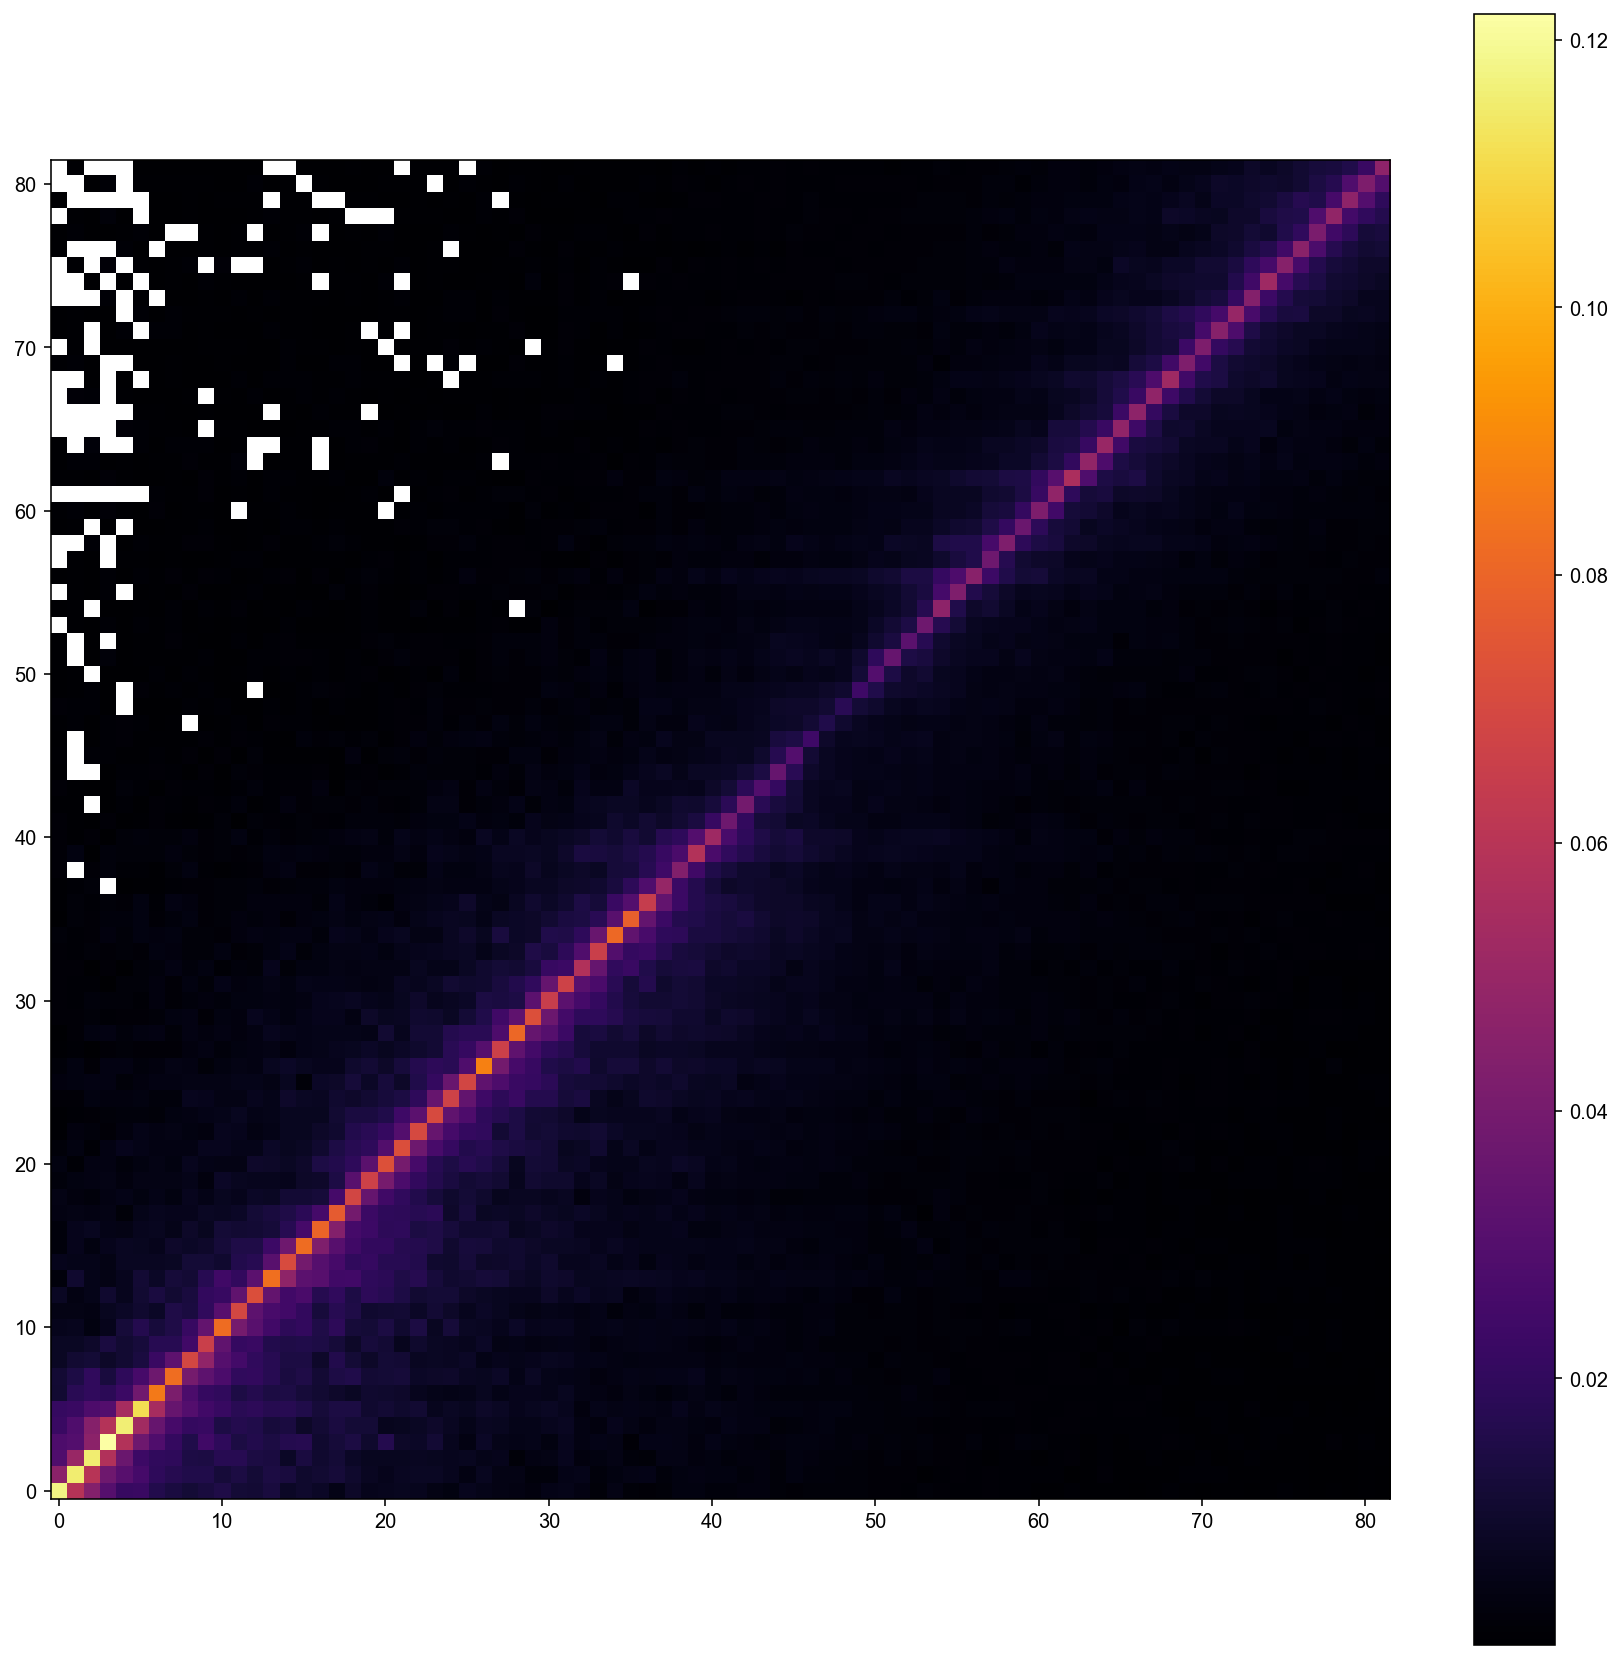

In [104]:
im = pivoted.iloc[50:, 50:].values.copy()
print(np.sum(im, axis=0))

#for i in range(0, im.shape[0]-1):
#    row = im[i, :]
#    im[i, 0:(i+1)] /= row[(i+1):0:-1]

plt.figure(figsize=(15,15))
plt.imshow(im, cmap='inferno', origin='lower')
plt.colorbar()

plt.show()